In [1]:
!pip install tensorflowjs
!pip install TensorFlow
# !pip install TensorFlow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.5.0 requires fsspec[http]<=2024.12.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
nilearn 0.11.1 requires scikit-learn>=1.4.0, but you have scikit-learn 1.2.2 which is incompatible.
pandas-gbq 0.26.1 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.5 which is 

# Import Library

In [2]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow import keras
from tensorflow.keras.applications import MobileNet,EfficientNetB0, InceptionV3,ResNet50
from tensorflow.keras.layers import GlobalMaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score,recall_score, f1_score


2025-04-16 06:43:08.771776: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744785788.976319      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744785789.035002      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load Data

In [3]:
train_val_path = '/kaggle/input/skin-disease-dataset/skin-disease-datasaet/train_set'
test_path = '/kaggle/input/skin-disease-dataset/skin-disease-datasaet/test_set'

datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='reflect'
)

train_data = []
val_data = []

train_class_counts = {}
val_class_counts ={}

for folder in sorted(os.listdir(train_val_path)):
    folder_path = os.path.join(train_val_path, folder)
    file = os.listdir(folder_path)
    num_train = int(0.8 * len(file))
    files_train = random.sample(file, num_train)
    files_val = list(set(file) - set(files_train))
    
    train_class_counts[folder] = 0
    val_class_counts[folder] = 0
    
    for file in files_train:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224, 224)) 
        train_data.append((img, folder))

        img_array = np.expand_dims(img, axis=0)

        for _ in range(2):
            augmented_img = next(datagen.flow(img_array, batch_size=1))[0].astype(np.uint8)
            train_data.append((augmented_img, folder))

        
        train_class_counts[folder] += 3  

    for file in files_val:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224, 224))
        val_data.append((img, folder))
        
        val_class_counts[folder] += 1 

test_data = []
test_class_counts = {}

for folder in sorted(os.listdir(test_path)):
    folder_path = os.path.join(test_path, folder)
    files_test = os.listdir(folder_path)
    test_class_counts[folder] = 0
    for file in files_test:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224, 224)) 
        test_data.append((img, folder))
        img_array = np.expand_dims(img, axis=0)
        test_class_counts[folder] += 1  
    
for class_name, count in train_class_counts.items():
    print(f"Kelas '{class_name}' dalam data TRAIN {count} gambar.")

for class_name, count in val_class_counts.items():
    print(f"Kelas '{class_name}' dalam data VALIDASI {count} gambar.")
    
for class_name, count in test_class_counts.items():
    print(f"Kelas '{class_name}' dalam data TEST {count} gambar.")


Kelas 'BA- cellulitis' dalam data TRAIN 324 gambar.
Kelas 'BA-impetigo' dalam data TRAIN 192 gambar.
Kelas 'FU-athlete-foot' dalam data TRAIN 297 gambar.
Kelas 'FU-nail-fungus' dalam data TRAIN 309 gambar.
Kelas 'FU-ringworm' dalam data TRAIN 216 gambar.
Kelas 'PA-cutaneous-larva-migrans' dalam data TRAIN 240 gambar.
Kelas 'VI-chickenpox' dalam data TRAIN 324 gambar.
Kelas 'VI-shingles' dalam data TRAIN 312 gambar.
Kelas 'BA- cellulitis' dalam data VALIDASI 28 gambar.
Kelas 'BA-impetigo' dalam data VALIDASI 16 gambar.
Kelas 'FU-athlete-foot' dalam data VALIDASI 25 gambar.
Kelas 'FU-nail-fungus' dalam data VALIDASI 26 gambar.
Kelas 'FU-ringworm' dalam data VALIDASI 18 gambar.
Kelas 'PA-cutaneous-larva-migrans' dalam data VALIDASI 20 gambar.
Kelas 'VI-chickenpox' dalam data VALIDASI 28 gambar.
Kelas 'VI-shingles' dalam data VALIDASI 26 gambar.
Kelas 'BA- cellulitis' dalam data TEST 34 gambar.
Kelas 'BA-impetigo' dalam data TEST 20 gambar.
Kelas 'FU-athlete-foot' dalam data TEST 32 gambar

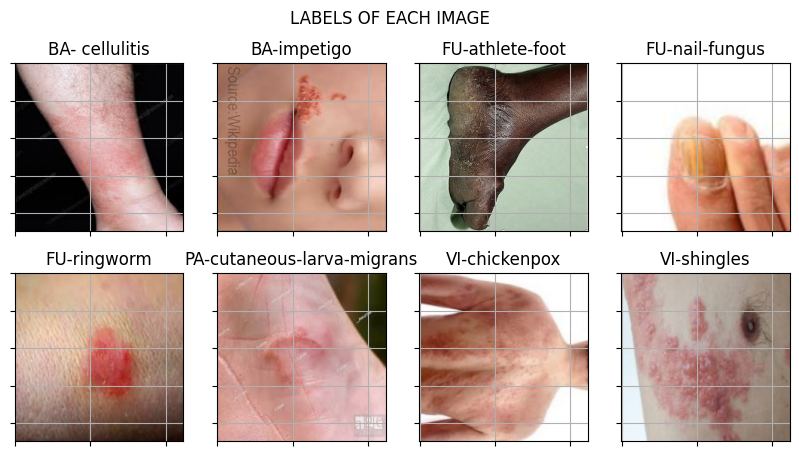

In [4]:
import matplotlib.pyplot as plt

class_images = {}

for img, label in train_data:
    if label not in class_images:
        class_images[label] = img

fig, axes = plt.subplots(2, 4, figsize=(10, 5))
plt.suptitle('LABELS OF EACH IMAGE')

for (label, img), ax in zip(class_images.items(), axes.flatten()):
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.grid(True)
    ax.set_title(label)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.show()


In [5]:
# tf.keras.backend.clear_session()

# # base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= (224,224,3))
# base_model.trainable = False

# num_classes = 23
# x = GlobalMaxPooling2D()(base_model.output)

# x = Dense(512, activation='relu', kernel_initializer='he_normal')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.5)(x)
   
# predictions = Dense(num_classes, activation='softmax')(x)


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers

# Define image input shape and number of classes
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Assuming train_gen is already defined
# class_count = len(list(train_gen.class_indices.keys()))
class_names = sorted(set(label for _, label in train_data))
class_count = len(class_names)

# Clear previous sessions
tf.keras.backend.clear_session()

# Load EfficientNetB3 as base model with global max pooling
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=img_shape,
    pooling='max'  # replaces GlobalMaxPooling2D
)
base_model.trainable = False  # freeze base model

# Build Sequential model
# model = Sequential([
#     base_model,
#     BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
#     Dense(256,
#           kernel_regularizer=regularizers.l2(0.016),
#           activity_regularizer=regularizers.l1(0.006),
#           bias_regularizer=regularizers.l1(0.006),
#           activation='relu'),
#     Dropout(rate=0.45, seed=123),
#     Dense(class_count, activation='softmax')
# ])
model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256,
          # kernel_regularizer=regularizers.l2(0.016),
          # activity_regularizer=regularizers.l1(0.006),
          # bias_regularizer=regularizers.l1(0.006),
          kernel_initializer='he_normal',
          activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary
model.summary()

I0000 00:00:1744785826.514576      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 1280)                │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,384,683 (16.73 MB)

 Trainable params: 332,552 (1.27 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [7]:
# model = Model(inputs=base_model.input, outputs=predictions)
# model.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy'])
# print(model.summary())

In [8]:
# from tensorflow.keras.optimizers import Adam, Adamax
# model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])
# model.summary()

In [9]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

X_train, y_train = zip(*train_data)
X_val, y_val = zip(*val_data)

X_train = preprocess_input(np.array(X_train))
X_val = preprocess_input(np.array(X_val))

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)

y_train_one_hot = to_categorical(y_train_encoded, class_count)
y_val_one_hot = to_categorical(y_val_encoded, class_count)



# Training Model

In [10]:
# EPOCHS = 100
# BATCH_SIZE = 32

# best_model_dir = '/kaggle/working/'
# early_stopping = EarlyStopping(monitor='val_loss', patience=15)
# model_checkpoint = ModelCheckpoint(
#     os.path.join(best_model_dir, 'best_model_EfficientNetB0.h5'),
#     monitor='val_loss', 
#     save_best_only=True,
#     mode='min', 
#     verbose=1
# )

# history = model.fit(X_train, y_train_one_hot,
#                     validation_data=(X_val, y_val_one_hot),
#                     epochs=EPOCHS, 
#                     batch_size=BATCH_SIZE,
#                     callbacks=[early_stopping, model_checkpoint])

import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

EPOCHS = 100
BATCH_SIZE = 32

best_model_dir = '/kaggle/working/'
early_stopping = EarlyStopping(monitor='val_loss', patience=15)

model_checkpoint = ModelCheckpoint(
    os.path.join(best_model_dir, 'best_model_EfficientNetB0.keras'),  # ✅ fixed extension
    monitor='val_loss', 
    save_best_only=True,
    mode='min', 
    verbose=1
)

history = model.fit(X_train, y_train_one_hot,
                    validation_data=(X_val, y_val_one_hot),
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE,
                    callbacks=[early_stopping, model_checkpoint])


Epoch 1/100


I0000 00:00:1744785845.040069     108 service.cc:148] XLA service 0x7b8cdc0519c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744785845.040788     108 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744785846.755761     108 cuda_dnn.cc:529] Loaded cuDNN version 90300


 7/70 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.1829 - loss: 2.8508

I0000 00:00:1744785855.849481     108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.5042 - loss: 1.6247
Epoch 1: val_loss improved from inf to 0.41505, saving model to /kaggle/working/best_model_EfficientNetB0.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 323ms/step - accuracy: 0.5064 - loss: 1.6166 - val_accuracy: 0.8503 - val_loss: 0.4150
Epoch 2/100
68/70 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8437 - loss: 0.4531
Epoch 2: val_loss improved from 0.41505 to 0.25563, saving model to /kaggle/working/best_model_EfficientNetB0.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8441 - loss: 0.4518 - val_accuracy: 0.9198 - val_loss: 0.2556
Epoch 3/100
68/70 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8975 - loss: 0.2811
Epoch 3: val_loss improved from 0.25563 to 0.21107, saving model to /kaggle/working/best_model_EfficientNetB0.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8975 - loss: 0.2812 - val_accuracy: 0.9251 - val_loss: 0.2111
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accur

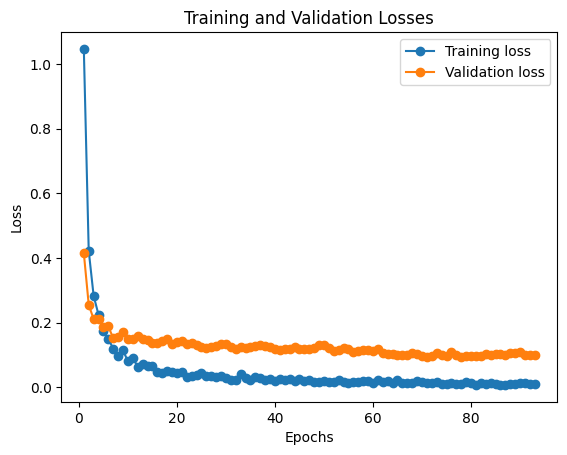

In [15]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss,label='Training loss', marker='o')
plt.plot(epochs, val_loss,label='Validation loss', marker='o')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

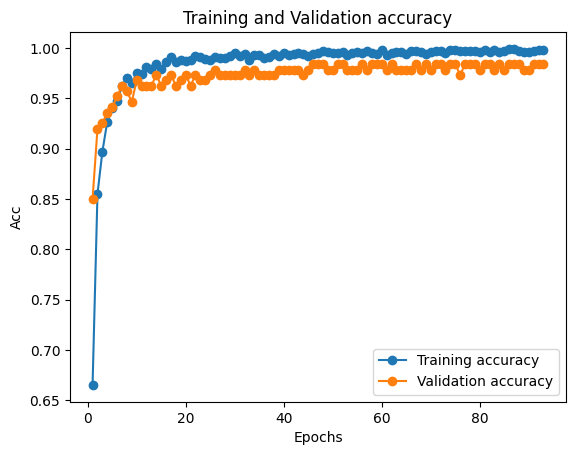

In [16]:
train_loss = history.history['accuracy']
val_loss = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss,label='Training accuracy', marker='o')
plt.plot(epochs, val_loss,label='Validation accuracy', marker='o')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()

# Evaluasi Model

In [13]:
test_path = '/kaggle/input/skin-disease-dataset/skin-disease-datasaet/test_set'

In [25]:
# model = load_model('/kaggle/working/best_model_EfficientNetB0.h5') 

In [17]:
real_label = []
predicted_class = []

for folder in sorted(os.listdir(test_path)):
    folder_path = os.path.join(test_path, folder)
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        img = preprocess_input(np.array([img]))  

        predictions = model.predict(img)
        real_label.append(folder)
        predicted_class_index = np.argmax(predictions)
        predicted_class.append(le.classes_[predicted_class_index])


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━

In [18]:
real_labels = np.array(real_label)
predicted_classes = np.array(predicted_class)

accuracy = accuracy_score(real_labels, predicted_classes)
precision = precision_score(real_labels, predicted_classes, average='weighted')
recall = recall_score(real_labels, predicted_classes, average='weighted')
f1 = f1_score(real_labels, predicted_classes, average='weighted')

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9786
Precision: 0.9793
Recall: 0.9786
F1 Score: 0.9787


In [19]:
real_labels = np.array(real_label)
predicted_classes = np.array(predicted_class)

conf_matrix = confusion_matrix(real_labels, predicted_classes)

class_names = [str(i) for i in range(len(conf_matrix))] 
print(classification_report(real_labels, predicted_classes, target_names=class_names))


              precision    recall  f1-score   support

           0       0.94      0.94      0.94        34
           1       1.00      1.00      1.00        20
           2       1.00      0.97      0.98        32
           3       1.00      0.97      0.98        33
           4       1.00      0.96      0.98        23
           5       0.96      1.00      0.98        25
           6       1.00      1.00      1.00        34
           7       0.94      1.00      0.97        33

    accuracy                           0.98       234
   macro avg       0.98      0.98      0.98       234
weighted avg       0.98      0.98      0.98       234



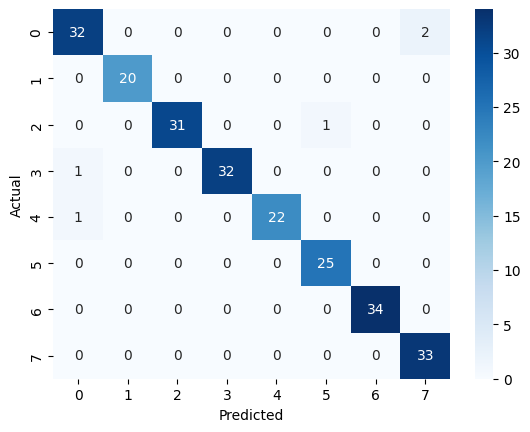

In [20]:
conf_matrix = confusion_matrix(real_label, predicted_class)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [21]:
def predict_single_image(image_path, model, label_encoder, img_size=(224, 224)):
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, img_size)
    img_array = np.expand_dims(img_resized, axis=0)
    img_preprocessed = preprocess_input(img_array)

    prediction = model.predict(img_preprocessed)
    predicted_index = np.argmax(prediction)
    predicted_label = label_encoder.classes_[predicted_index]

    # Display image with prediction
    plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted Label: {predicted_label}")
    plt.axis('off')
    plt.show()

    return predicted_label


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


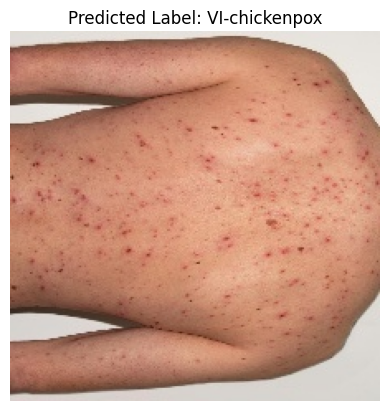

Predicted class: VI-chickenpox


In [24]:
sample_image_path = '/kaggle/input/skin-disease-dataset/skin-disease-datasaet/test_set/VI-chickenpox/168_VI-chickenpox (25).jpg'
predicted = predict_single_image(sample_image_path, model, le)
print("Predicted class:", predicted)